In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass
print("done")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

done


In [2]:
!pip install torch-summary

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, Subset
from PIL import Image
import itertools

In [4]:
class KANLinear(torch.nn.Module):
    def __init__(self, in_features, out_features, grid_size=5, spline_order=3, scale_noise=0.1, scale_base=1.0,
                 scale_spline=1.0, enable_standalone_scale_spline=True, base_activation=torch.nn.SiLU, grid_eps=0.02,
                 grid_range=[-1, 1]):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, grid_size + spline_order) sized tensor, which is
        extremely slow and consumes a lot of memory.
        """
        weight = self.scaled_spline_weight
        activation = self.base_activation(self.base_weight)
        activation_regularization = weight.square().mean()
        entropy_regularization = (
            -weight.softmax(dim=-1) * weight.log_softmax(dim=-1)
        ).mean()
        regularization = (
            regularize_activation * activation_regularization
            + regularize_entropy * entropy_regularization
        )
        return regularization




import done
cuda
model init
transform done
dataset done
loaders done
training start
epoch: 1
Epoch: 1 [448/4569 (10%)]	Loss: 0.109667
Epoch: 1 [960/4569 (21%)]	Loss: 0.103514
Epoch: 1 [1472/4569 (32%)]	Loss: 0.091462
Epoch: 1 [1984/4569 (43%)]	Loss: 0.076519
Epoch: 1 [2496/4569 (54%)]	Loss: 0.071759
Epoch: 1 [3008/4569 (65%)]	Loss: 0.070769
Epoch: 1 [3520/4569 (76%)]	Loss: 0.072796
Epoch: 1 [4032/4569 (88%)]	Loss: 0.061033
Epoch: 1 [1775/4569 (99%)]	Loss: 0.056212
epoch: 2
Epoch: 2 [448/4569 (10%)]	Loss: 0.053332
Epoch: 2 [960/4569 (21%)]	Loss: 0.050376
Epoch: 2 [1472/4569 (32%)]	Loss: 0.046832
Epoch: 2 [1984/4569 (43%)]	Loss: 0.042396
Epoch: 2 [2496/4569 (54%)]	Loss: 0.043280
Epoch: 2 [3008/4569 (65%)]	Loss: 0.044368
Epoch: 2 [3520/4569 (76%)]	Loss: 0.039798
Epoch: 2 [4032/4569 (88%)]	Loss: 0.043337
Epoch: 2 [1775/4569 (99%)]	Loss: 0.046688
epoch: 3
Epoch: 3 [448/4569 (10%)]	Loss: 0.039920
Epoch: 3 [960/4569 (21%)]	Loss: 0.036318
Epoch: 3 [1472/4569 (32%)]	Loss: 0.031196
Epoch: 3 [198

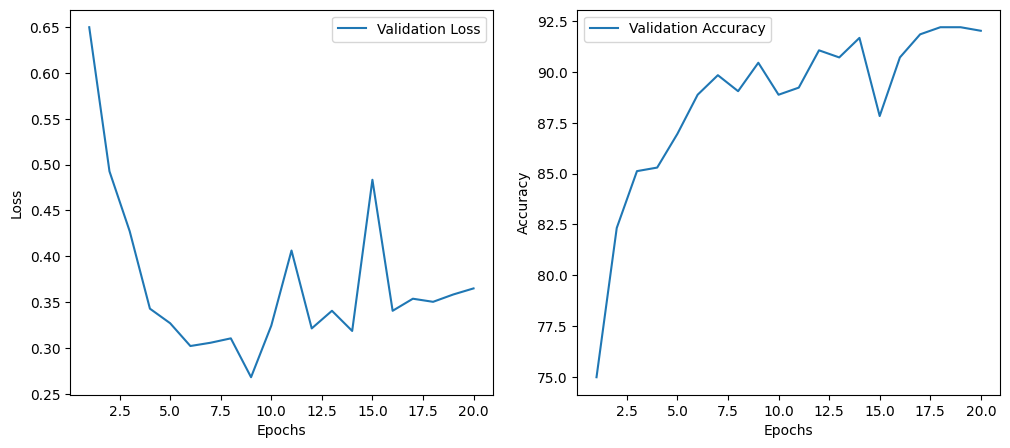

Test set: Average loss: 0.3482, Accuracy: 93.44%


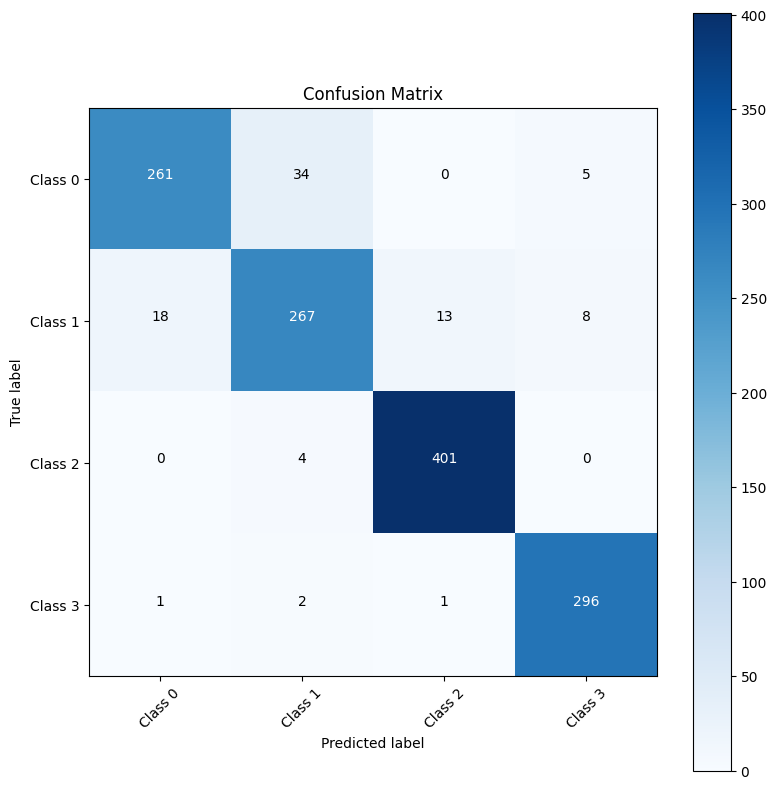

Precision: 0.9340, Recall: 0.9344, F1-score: 0.9339


In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, Subset
from PIL import Image
import itertools
print("import done")
# Define the dataset class
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        for class_id, class_dir in enumerate(sorted(os.listdir(root_dir))):
            class_path = os.path.join(root_dir, class_dir)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                self.data.append((img_path, class_id))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        return image, label

# Define the CNN with KANLinear layers
class CNNKAN(nn.Module):
    def __init__(self):
        super(CNNKAN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  # Update this line
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)  # Update this line
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define training function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
        if batch_idx % 8 == 7:
            print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {running_loss / 100:.6f}')
            running_loss = 0.0
    return running_loss / len(train_loader), correct / total

# Define evaluation function
def evaluate(model, device, loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_targets = []
    all_preds = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_targets.extend(target.cpu().numpy())
            all_preds.extend(pred.cpu().numpy().flatten())

    test_loss /= len(loader.dataset)
    accuracy = 100. * correct / len(loader.dataset)
    return test_loss, accuracy, all_targets, all_preds

# Function to plot metrics
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    #plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    #plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Function to plot ROC curves
def plot_roc_curve(y_true, y_scores, n_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.show()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("cuda")
# Initialize the model
model = CNNKAN().to(device)
print("model init")
# Hyperparameters
batch_size = 64
epochs = 20
learning_rate = 0.005
momentum = 0.9

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
print("transform done")
# Load dataset
dataset = BrainTumorDataset(root_dir='/kaggle/input/brain-tumor-mri-dataset/Training', transform=transform)
train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
print("dataset done")
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = BrainTumorDataset(root_dir='/kaggle/input/brain-tumor-mri-dataset/Testing', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("loaders done")
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
print("training start")
for epoch in range(1, epochs + 1):
    print("epoch: "+ str(epoch))
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
    val_loss, val_accuracy, _, _ = evaluate(model, device, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

# Plot loss and accuracy curves
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

# Evaluate on test set
test_loss, test_accuracy, test_targets, test_preds = evaluate(model, device, test_loader)
print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%')

# Confusion matrix
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']
cm = confusion_matrix(test_targets, test_preds)
plot_confusion_matrix(cm, class_names)

# Precision, recall, F1-score
precision, recall, f1, _ = precision_recall_fscore_support(test_targets, test_preds, average='weighted')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

# ROC curves
test_probs = np.array([F.softmax(model(data.to(device)), dim=1).detach().cpu().numpy() for data, _ in test_loader])
test_probs = np.concatenate(test_probs, axis=0)
test_targets_onehot = np.eye(len(class_names))[test_targets]
plot_roc_curve(test_targets_onehot, test_probs, len(class_names))

